# 🧼 Preprocessing & Modeling – IEEE-CIS Fraud Detection

## 1. Introduction

In this notebook, we implement the preprocessing pipeline and baseline models for the IEEE-CIS Fraud Detection dataset.

We use the pre-cleaned data stored in `data/processed/train_clean.csv` and apply the following steps:

- Imputation of missing values
- Label encoding of categorical variables
- Feature scaling
- Train-test split
- Evaluation of baseline models (Logistic Regression and Random Forest)

## 1.1 🧰 Loading libraries

In [14]:
# ─── Core ─────────────────────────────────────────────
import os
import sys
import pandas as pd
import numpy as np

# ─── Add project src directory to sys.path ─────────────
# Navigate one level up from the notebook (notebooks/ → root/)
notebook_dir = os.path.abspath("")  # current working dir where notebook runs
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# ─── Visualization ────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
from visual_config import set_plot_style

# ─── Modeling ──────────────────────────────────────────
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ─── Preprocessing ─────────────────────────────────────
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# ─── Config ────────────────────────────────────────────
import warnings
warnings.filterwarnings("ignore")
set_plot_style()

## 2. ✅ Load and merge of the dataset (baseline model)

In [2]:
# Load training datasets
transaction_path = os.path.join(project_root, "data", "ieee-fraud-detection", "train_transaction.csv")
identity_path = os.path.join(project_root, "data", "ieee-fraud-detection", "train_identity.csv")

train_transaction = pd.read_csv(transaction_path)
train_identity = pd.read_csv(identity_path)

# Merge datasets using left join on TransactionID
train_data = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

print(f"✅ train_transaction shape: {train_transaction.shape}")
print(f"✅ train_identity shape:    {train_identity.shape}")
print(f"✅ merged train_data shape: {train_data.shape}")

✅ train_transaction shape: (590540, 394)
✅ train_identity shape:    (144233, 41)
✅ merged train_data shape: (590540, 434)


In [3]:
from data_preprocessing import save_processed_data
save_processed_data(train_data)

✅ Processed data saved to /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/data/processed/train_clean.csv


## 3. Preprocessing

### 3.1 Handling Missing Values

We handle missing values using simple imputation strategies. For numerical features, we use the median. For categorical ones, the most frequent value.

In [4]:
# importing functions from src/data_preprocessing.py
from data_preprocessing import impute_missing_values, encode_categorical, scale_features

In [5]:
# Impute missing values (SimpleImputer)
train_data = impute_missing_values(train_data)
print("✅ Missing values imputed.")

✅ Missing values imputed.


### 3.2 Encoding Categorical Variables

Categorical features are label encoded to convert them into numerical format required by ML models.

In [6]:
train_data = encode_categorical(train_data)
print("✅ Categorical features encoded.")

✅ Categorical features encoded.


In [7]:
# save the processed data
save_processed_data(train_data, "train_final_ready.csv")

✅ Processed data saved to /Users/alexmatias/Documents/My Work/My work Software/Proyectos Data Science/To the portfolio/Fraud-Detection-with-ML/data/processed/train_final_ready.csv


## 4. Train-Test Split

We split the preprocessed dataset into training and test sets using a 80/20 ratio. The target variable is `isFraud`, and we apply stratification to preserve class imbalance during the split.

In [8]:
# Separate features and target
X = train_data.drop("isFraud", axis=1)
y = train_data["isFraud"]

# Scale only features
X = scale_features(X)

In [9]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"✅ Train shape: {X_train.shape}")
print(f"✅ Test shape:  {X_test.shape}")

✅ Train shape: (472432, 433)
✅ Test shape:  (118108, 433)


## 5. Baseline Models

### 5.1 Logistic Regression

We train a baseline `Logistic Regression` model to establish a performance reference. We evaluate it using confusion matrix, classification report, and ROC AUC score.

In [10]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

#### 5.1.1 Evaluation of the model

We evaluate how good this models performs through

- Confussion matrix
- ROC AUC score
- ROC curve

In [12]:
# Evaluation
print("🔍 Classification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr))

print("🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

🔍 Classification Report (Logistic Regression):

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    113975
         1.0       0.82      0.26      0.40      4133

    accuracy                           0.97    118108
   macro avg       0.90      0.63      0.69    118108
weighted avg       0.97      0.97      0.97    118108

🔍 Confusion Matrix:
[[113743    232]
 [  3043   1090]]


✅ ROC AUC: 0.8559


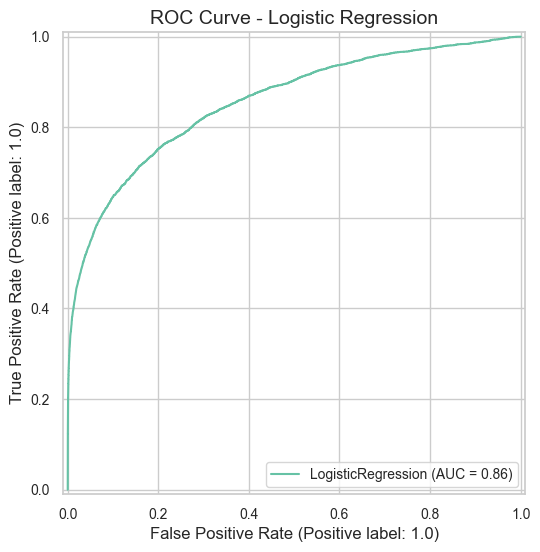

In [15]:
roc_auc = roc_auc_score(y_test, y_proba_lr)
print(f"✅ ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(lr_model, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

### 5.1.2 Model Evaluation Summary

- **AUC Score**: 0.856
- **Precision (Fraud class)**: 0.82
- **Recall (Fraud class)**: 0.26 → ⚠️ Indicates high false negatives
- **Confusion Matrix**:  
  - True Negatives: 113,743  
  - False Positives: 232  
  - False Negatives: 3,043  
  - True Positives: 1,090

**Comment**:  
The model achieves high accuracy, but recall for fraud detection is low. This is expected for a baseline logistic regression in imbalanced datasets. Further models should address this, e.g., Random Forest with class weights or SMOTE.

### 5.2 Random Forest

In [16]:
# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]


In [17]:
# Evaluation
print("🔎 Classification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))

print("🔎 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

🔎 Classification Report (Random Forest):

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113975
         1.0       0.94      0.45      0.61      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.72      0.80    118108
weighted avg       0.98      0.98      0.98    118108

🔎 Confusion Matrix:
[[113860    115]
 [  2279   1854]]


✅ ROC AUC: 0.9326


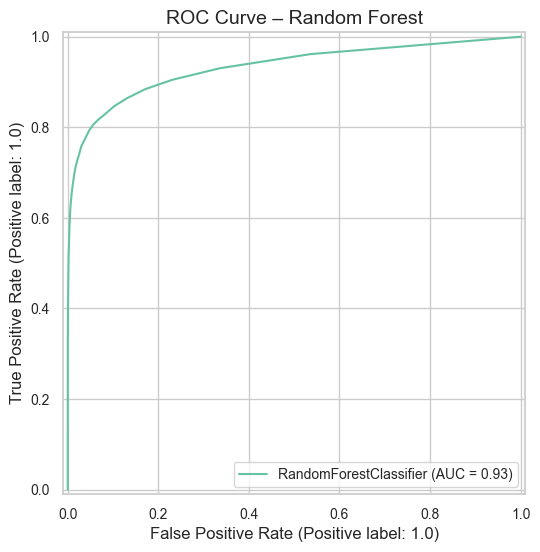

In [18]:
# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"✅ ROC AUC: {roc_auc_rf:.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve – Random Forest")
plt.show()

### Key Findings:

- 🔍 **Random Forest** significantly outperforms **Logistic Regression**, especially in detecting fraud cases.
- ⚠️ Despite improvement, recall for fraud class remains moderate (~45%), suggesting room for optimization (e.g., feature selection, class balancing).
- ✅ **ROC AUC** improved from **0.86** (LR) to **0.93** (RF), indicating better discrimination capacity.

### Next Steps:

- Try more advanced models (e.g., XGBoost, LightGBM).
- Perform hyperparameter tuning.
- Explore class balancing techniques (e.g., SMOTE, class weights).

## 6. Final Remarks